# **Booking rating**

## **0. Введение**


#### ***Проблема***: 
    Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании - это нечестные отели, которые накручивают себе рейтинг.

#### ***Цель проекта***: 
    Подготовить данные для обучения модели, за счет чего улучшить параметр MAPE и получить более качественные выходные данные, генерируемые моделью.
    
#### ***Задачи проекта***:
*  ознакомиться с входными данными (датасет с информацией об отелях);
*  изучить пример машинного обучения (scikit-learn класс RandomForestRegressor);
*  выполнить подготовку данных, которые будут использованы для обучения модели;
*  проверить эффективность предлагаемой модели, используя метрику MAPE;
*  принять участие в соревнованиях на площадке kaggle.com.


Выполнение подготовки данных сводится к таким действиям:

    Удаление строковых значений.
    Очистка от пропущенных значений.
    Создание новых признаков.
    Преобразование признаков.
    Отбор признаков.



## **1. Подготовительный этап, подгрузка данных**

In [1]:
!pip install twython 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import time

import geopy.distance

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import category_encoders as ce 

from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [10]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## **2. Исследование данных**

In [13]:
# посмотрим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 



### ***Признаки:***

*     hotel_address — адрес отеля;
*     review_date — дата, когда рецензент разместил соответствующий отзыв;
*     average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
*     hotel_name — название отеля;
*     reviewer_nationality — страна рецензента;
*     negative_review — отрицательный отзыв, который рецензент дал отелю;
*     review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
*     positive_review — положительный отзыв, который рецензент дал отелю;
*     review_total_positive_word_counts — общее количество слов в положительном отзыве;
*     reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
*     total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
*     total_number_of_reviews — общее количество действительных отзывов об отеле;
*     tags — теги, которые рецензент дал отелю;
*     days_since_review — количество дней между датой проверки и датой очистки;
*     additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
*     lat — географическая широта отеля;
*     lng — географическая долгота отеля.


In [14]:
# посмотрим на размерность датасета
data.shape

(515738, 18)

Итак, в таблице 515738 строк и 18 признаков. Узнаем, сколько пропусков есть в таблице и в каких признаках.

In [15]:
# найдем признаки с пропусками и количество пустых значений в этих признаках
cols_null = data.isnull().sum()
cols_with_null = cols_null[cols_null>0].sort_values(ascending=False)
display(cols_with_null)

lat    3268
lng    3268
dtype: int64

Пропусков мало, но они есть. Нужно будет их заполнить. 
Поищем дубликаты и посмотрим на них.

In [16]:
# поиск дубликатов 
dupl_columns = list(data.columns)

mask = data.duplicated(subset=dupl_columns)
df_duplicates = data[mask]
print(f'Число найденных дубликатов: {df_duplicates.shape[0]}')

Число найденных дубликатов: 336


In [17]:
df_duplicates.sort_values(['hotel_address','review_date']).head(6)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
269304,16 22 Great Russell Street Camden London WC1B ...,300,7/27/2017,9.0,The Bloomsbury Hotel,Israel,No Negative,0,1254,The attention received by Sebastian and his t...,12,4,"[' Leisure trip ', ' Couple ', ' Superior Doub...",7 days,51.517167,-0.129053,1,9.6
243265,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,United Kingdom,Evry thing of this place i can t name horlrel...,58,165,This hotel is worst hotel Its terrible,9,1,"[' Solo traveler ', ' Single Room ', ' Stayed ...",293 day,48.887128,2.314205,1,2.5
268200,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,Iran,Evry thing was wrong Cold room Dark room No r...,21,165,This hotel was terrible this place worst plac...,29,2,"[' Solo traveler ', ' Single Room ', ' Stayed ...",293 day,48.887128,2.314205,1,2.5
403775,167 rue de Rome 17th arr 75017 Paris France,11,10/18/2016,6.8,Villa Eugenie,Israel,No Negative,0,165,the room was very french and beautiful it was...,18,1,"[' Leisure trip ', ' Couple ', ' Twin Room ', ...",289 day,48.887128,2.314205,1,9.2
459300,167 rue de Rome 17th arr 75017 Paris France,11,10/2/2016,6.8,Villa Eugenie,Qatar,Staff very rude My credit card was charged Be...,56,165,Nothing,3,8,"[' Leisure trip ', ' Family with young childre...",305 day,48.887128,2.314205,1,5.0
122978,167 rue de Rome 17th arr 75017 Paris France,11,12/12/2016,6.8,Villa Eugenie,Canada,Listed above,3,165,It was a terrible stat unfriendly staff very ...,13,1,"[' Business trip ', ' Solo traveler ', ' Stand...",234 day,48.887128,2.314205,0,0.0


In [18]:
data[(data['hotel_address'] == '167 rue de Rome 17th arr 75017 Paris France') & (data['review_date'] == '10/14/2016')]

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
65930,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,Albania,They didnt change the sheets They also had a ...,40,165,The room was cozy and pretty,7,3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",293 day,48.887128,2.314205,0,0.0
172918,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,Iran,Evry thing was wrong Cold room Dark room No r...,21,165,This hotel was terrible this place worst plac...,29,2,"[' Solo traveler ', ' Single Room ', ' Stayed ...",293 day,48.887128,2.314205,1,2.5
226364,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,United Kingdom,Evry thing of this place i can t name horlrel...,58,165,This hotel is worst hotel Its terrible,9,1,"[' Solo traveler ', ' Single Room ', ' Stayed ...",293 day,48.887128,2.314205,1,2.5
243265,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,United Kingdom,Evry thing of this place i can t name horlrel...,58,165,This hotel is worst hotel Its terrible,9,1,"[' Solo traveler ', ' Single Room ', ' Stayed ...",293 day,48.887128,2.314205,1,2.5
268200,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,Iran,Evry thing was wrong Cold room Dark room No r...,21,165,This hotel was terrible this place worst plac...,29,2,"[' Solo traveler ', ' Single Room ', ' Stayed ...",293 day,48.887128,2.314205,1,2.5
348180,167 rue de Rome 17th arr 75017 Paris France,11,10/14/2016,6.8,Villa Eugenie,Albania,They didnt change the sheets They also had a ...,40,165,The room was cozy and pretty,7,3,"[' Leisure trip ', ' Couple ', ' Standard Doub...",293 day,48.887128,2.314205,1,5.8


Да, это дублирующиеся строки. Но при этом есть одинаковые строки с разным значением sample: одна строка из тренировочной и одна из тестовой таблицы. 
Удаление дубликатов отрицательно влияет на метрику. Оставляем их на месте.




In [19]:
#Сколько уникальных названий отелей представлено в наборе данных?
data['hotel_name'].nunique()

1492

In [20]:
#Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
#Когда был оставлен самый первый отзыв? Введите ответ в формате yyyy-mm-dd.
data['review_date'] = pd.to_datetime(data['review_date'])

print('Самый старый отзыв: ', {data['review_date'].min()})
print('Самый свежий отзыв: ', {data['review_date'].max()})

Самый старый отзыв:  {Timestamp('2015-08-04 00:00:00')}
Самый свежий отзыв:  {Timestamp('2017-08-03 00:00:00')}


В датасете есть отзывы за половину 2015 года (с августа), за весь 2016 года и за половину 2017 (до августа).

In [21]:
# Самая высокая и самая низкая оценка
print(data[data['sample']==1]['reviewer_score'].min())
print(data[data['sample']==1]['reviewer_score'].max())

2.5
10.0


В датасете представлены данные с несколькими типами данных: числовой, тип object, датавремя.
Есть признаки, которые относятся к отелю, к ревьюверу, и сами отзывы. 

К отелю:

- hotel_address — адрес отеля;
- hotel_name — название отеля;
- lat — географическая широта отеля;
- lng — географическая долгота отеля.
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за    последний год;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

К ревьюверу:

- reviewer_nationality — страна рецензента;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

К отзывам:

- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве;
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;



Будем рассматривать их последовательно.


## **3. Обработка признаков**



## 1) Признаки, связанные с отелем.

Рассмотрим признак с адресом отеля.

In [22]:
# посмотрим на адреса 
print(data['hotel_address'].iloc[56])
print(data['hotel_address'].iloc[2556])
print(data['hotel_address'].iloc[42556])
print(data['hotel_address'].iloc[20056])
print(data['hotel_address'].iloc[556])
print(data['hotel_address'].iloc[34578])
print(data['hotel_address'].iloc[40054])
print(data['hotel_address'].iloc[79423])

150 Bayswater Road Kensington and Chelsea London W2 4RT United Kingdom
Hafnersteig 7 01 Innere Stadt 1010 Vienna Austria
Las Ramblas 117 Ciutat Vella 08002 Barcelona Spain
8 10 Queensberry Place Kensington and Chelsea London SW7 2EA United Kingdom
Sancho de vila 32 34 Sant Mart 08018 Barcelona Spain
1 15 Templeton Place Earl s Court Kensington and Chelsea London SW5 9NB United Kingdom
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom
52 Chiswell Street City of London London EC1Y 4SD United Kingdom


Адреса содержат данные о стране и городе. Вынесем эти данные в отдельные признаки.

In [23]:
# создадим новый признак - страна country, возьмем ее из адреса
data['country'] = data['hotel_address'].apply(lambda x : 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])
data['country']

0                  Italy
1            Netherlands
2                  Spain
3                  Italy
4            Netherlands
               ...      
515733    United Kingdom
515734           Austria
515735    United Kingdom
515736    United Kingdom
515737    United Kingdom
Name: country, Length: 515738, dtype: object

In [24]:
# посмотрим, в каких странах находятся отели и где больше всего отзывов
data['country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

In [25]:
# статистическая информация по каждой стране
data[data['sample']==1].groupby('country')['reviewer_score'].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,29178.0,8.552642,1.507059,2.5,7.9,9.2,9.6,10.0
France,44830.0,8.420587,1.654414,2.5,7.5,8.8,9.6,10.0
Italy,27883.0,8.355482,1.639415,2.5,7.5,8.8,9.6,10.0
Netherlands,43006.0,8.449214,1.604041,2.5,7.5,8.8,9.6,10.0
Spain,45132.0,8.553747,1.555254,2.5,7.9,9.2,9.6,10.0
United Kingdom,196774.0,8.326884,1.669871,2.5,7.5,8.8,9.6,10.0


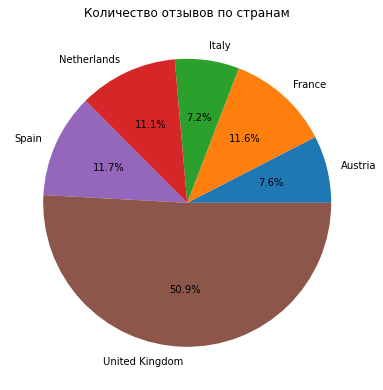

In [26]:
count_country = data.groupby(['country'])['reviewer_score'].count()

fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    count_country,
    labels=count_country.index,

    autopct='%.1f%%'
);
axes.set_title("Количество отзывов по странам");

country
Austria           8.552642
France            8.420587
Italy             8.355482
Netherlands       8.449214
Spain             8.553747
United Kingdom    8.326884
Name: reviewer_score, dtype: float64

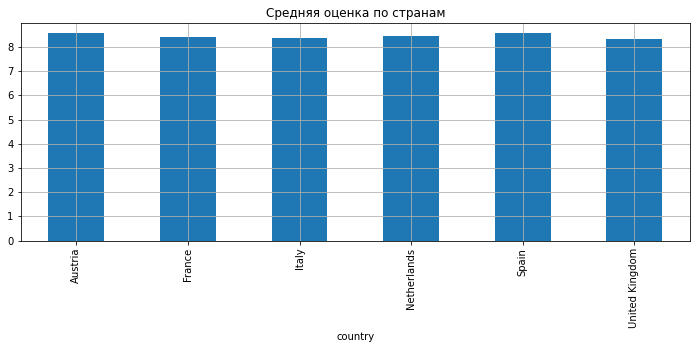

In [27]:
mask = data['sample']==1
df = data[mask]
mean_country = df.groupby(['country'])['reviewer_score'].mean()

mean_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    title = "Средняя оценка по странам"
);
mean_country
# средняя оценка почти одинаковая

In [28]:
# создадим новый признак - город city, возьмем его тоже из адреса
data['city'] = data['hotel_address'].apply(lambda x: x.split()[-2:-1][0])

# Проверим, везде ли город London в United Kindom
mask = data['country'] == 'United Kingdom'
dff = data[mask]

for_new_df = dff[dff['hotel_address'].str.contains('London')]
dff.shape == for_new_df.shape

True

In [29]:
# изменяем город на Лондон в United Kindom
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)
#посмотрим, в каких городах больше всего отзывов
data['city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

In [30]:
count_city = data.groupby(['country','city'])['reviewer_score'].count()
count_city

country         city     
Austria         Vienna        38939
France          Paris         59928
Italy           Milan         37207
Netherlands     Amsterdam     57214
Spain           Barcelona     60149
United Kingdom  London       262301
Name: reviewer_score, dtype: int64

В каждой стране по одному городу, эти признаки дублируют друг друга. Больше всего отзывов в United Kindom. По оценкам разницы почти нет. Посмотрим на признак с названием отеля.

In [31]:
#Сколько уникальных названий отелей представлено в наборе данных?
data['hotel_name'].nunique()

1492

In [32]:
#Сколько уникальных названий отелей представлено в каждой стране?
n = data.groupby(['country'])['hotel_name'].nunique()
n

country
Austria           158
France            458
Italy             162
Netherlands       105
Spain             211
United Kingdom    400
Name: hotel_name, dtype: int64

In [33]:
n.sum()

1494

In [34]:
# всего уникальных названий 1492, а по городам - 1494. 
#Значит какие-то отели имеют одинаковое название c другими и находятся в разных городах. Сеть отелей?
dff = data[['hotel_name','country']]
dff = dff.groupby(['hotel_name'])[['country']].nunique()
dff.sort_values(['country'], ascending = False)

,country
hotel_name,
Hotel Regina,3
11 Cadogan Gardens,1
Mercure Paris Gare Montparnasse,1
Mercure Paris Pigalle Sacre Coeur,1
Mercure Paris Opera Louvre,1
...,...
Ham Yard Hotel,1
Hallmark Hotel London Chigwell Prince Regent,1
HCC St Moritz,1


In [35]:
# Hotel Regina находится в разных странах, посмотрим в каких
mask = data['hotel_name'] == 'Hotel Regina'
data[mask]['country'].unique()

array(['Spain', 'Austria', 'Italy'], dtype=object)

Переходим к признакам, в которых есть пустые значения - координаты отеля. Их нужно заполнить.

In [36]:
#сначала посмотрим, у каких отелей нет координат
mask_lat = data['lat'].isnull()
mask_lng = data['lng'].isnull()
dff = data[mask_lat&mask_lng]

dff.groupby(['country', 'hotel_name'])['hotel_address'].nunique()

country  hotel_name                                      
Austria  Austria Trend Hotel Schloss Wilhelminenberg Wien    1
         City Hotel Deutschmeister                           1
         Cordial Theaterhotel Wien                           1
         Derag Livinghotel Kaiser Franz Joseph Vienna        1
         Fleming s Selection Hotel Wien City                 1
         Hotel Atlanta                                       1
         Hotel City Central                                  1
         Hotel Daniel Vienna                                 1
         Hotel Park Villa                                    1
         Hotel Pension Baron am Schottentor                  1
         Roomz Vienna                                        1
France   Holiday Inn Paris Montmartre                        1
         Maison Albar Hotel Paris Op ra Diamond              1
         Mercure Paris Gare Montparnasse                     1
Spain    Hotel Advance                                      

In [37]:
# посмотрим, в каком виде записаны в таблице координаты
data[['hotel_address','lat','lng']].head(5)

,hotel_address,lat,lng
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644


In [38]:
# получим список адресов, чтобы потом найти в инете координаты
dff['hotel_address'].unique()

array(['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eix

In [39]:
# создадим таблицу с адресами и координатами (координаты искала в интернете, 
# программно с помощью библиотеки у меня не получилось)

address_df = pd.DataFrame({'address': ['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',             #1
                                  '23 Rue Damr mont 18th arr 75018 Paris France',                 #2
                                  'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',  #3
                                  'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',     #4
                                  '4 rue de la P pini re 8th arr 75008 Paris France',             #5
                                  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',          #6
                                  'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',          #7
                                  'Bail n 4 6 Eixample 08010 Barcelona Spain',                    #8
                                  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',          #9
                                  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',       #10
                                  'Paragonstra e 1 11 Simmering 1110 Vienna Austria',             #11
                                  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',        #12
                                  '20 Rue De La Ga t 14th arr 75014 Paris France',                #13           
                                  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',            #14
                                  'Sep lveda 180 Eixample 08011 Barcelona Spain',                 #15
                                  'Pau Clar s 122 Eixample 08009 Barcelona Spain',                #16
                                  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria'],    #17
                       'lat' : [48.211783, 48.856663, 48.210918, 48.222139, 48.856663, 
                                48.245935, 48.218213, 41.396133, 48.222139, 48.206487,
                                48.176599, 48.222139, 48.838331, 48.778035, 41.425226,
                                41.504994, 48.210918],
                       'lng' : [16.297308, 2.351556, 16.347119, 16.357513, 2.351556, 
                                16.341397, 16.39411, 1.655829, 16.357513, 16.36346, 
                                16.413999, 16.357513, 2.330948, 15.65565, 2.181864, 
                                2.245959, 16.347119]
                      })
address_df

,address,lat,lng
0,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,48.211783,16.297308
1,23 Rue Damr mont 18th arr 75018 Paris France,48.856663,2.351556
2,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.210918,16.347119
3,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222139,16.357513
4,4 rue de la P pini re 8th arr 75008 Paris France,48.856663,2.351556
5,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,48.245935,16.341397
6,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.218213,16.394110
7,Bail n 4 6 Eixample 08010 Barcelona Spain,41.396133,1.655829
8,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.222139,16.357513
9,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,48.206487,16.363460


In [40]:
# Заполним координаты

def coordinates_fill(arg, address_df):
    
    ''' Функция сравнивает строки по адресу и заполняет координаты'''
    
    mask_address = address_df['address'] == arg['hotel_address']
    
    arg['lat'] = address_df[mask_address]['lat'].iloc[0]
    arg['lng'] = address_df[mask_address]['lng'].iloc[0]
    
    return arg


dff = dff.apply(lambda x: coordinates_fill( x, address_df), axis=1) 

# проверяем, как проставились координаты
dff[['hotel_address','hotel_name', 'country', 'lat', 'lng']]

,hotel_address,hotel_name,country,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,Hotel Atlanta,Austria,48.222139,16.357513
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,Hotel Atlanta,Austria,48.222139,16.357513
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,City Hotel Deutschmeister,Austria,48.222139,16.357513
526,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,France,48.856663,2.351556
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,Fleming s Selection Hotel Wien City,Austria,48.210918,16.347119
...,...,...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,Hotel City Central,Austria,48.218213,16.394110
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,Hotel City Central,Austria,48.218213,16.394110
515439,4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,France,48.856663,2.351556
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,Hotel City Central,Austria,48.218213,16.394110


In [41]:
# загрузим в таблицу
data[mask_lat&mask_lng] = dff
# проверим, есть ли еще значения NULL
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
city                                          0
dtype: int64

Все проставилось. Пустых значений больше нет.
Добавим новый признак - расстояние от отеля до центра города.

In [42]:
# координаты центра по городам
cities_dict = {
    'Paris'    : [48.8534100, 2.3488000],
    'London'   : [51.5085300, -0.1257400],
    'Barcelona': [41.3887900, 2.1589900],
    'Milan'    : [45.4642700, 9.1895100],
    'Vienna'   : [48.2084900, 16.3720800],
    'Amsterdam': [52.3740300, 4.8896900],
}

In [43]:
%%time
# рассчитаем расстояние отелей от центра города
def distance_to_center(city, lat, lng):
    
    return geopy.distance.geodesic([cities_dict[city][0], 
                                    cities_dict[city][1]],
                                   [lat, lng]).km

data['distance'] = data.apply(lambda x:
                                  distance_to_center(x.city, x.lat, x.lng), 
                                  axis = 1)
data[['hotel_address','hotel_name', 'country', 'lat', 'lng', 'distance']]

CPU times: user 3min 24s, sys: 409 ms, total: 3min 25s
Wall time: 3min 25s


,hotel_address,hotel_name,country,lat,lng,distance
0,Via Senigallia 6 20161 Milan Italy,Hotel Da Vinci,Italy,45.533137,9.171102,7.788060
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,Urban Lodge Hotel,Netherlands,52.385649,4.834443,3.978037
2,Mallorca 251 Eixample 08008 Barcelona Spain,Alexandra Barcelona A DoubleTree by Hilton,Spain,41.393192,2.161520,0.532699
3,Piazza Della Repubblica 17 Central Station 201...,Hotel Principe Di Savoia,Italy,45.479888,9.196298,1.815149
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,Hotel Esther a,Netherlands,52.370545,4.888644,0.394315
...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,Hotel Moonlight,United Kingdom,51.494028,-0.191050,4.813462
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,BEST WESTERN PLUS Amedia Wien,Austria,48.192379,16.399451,2.710922
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,Bloomsbury Palace Hotel,United Kingdom,51.520795,-0.131084,1.414063
515736,31 Great Cumberland Place Westminster Borough ...,The Marble Arch London,United Kingdom,51.515125,-0.160066,2.493368


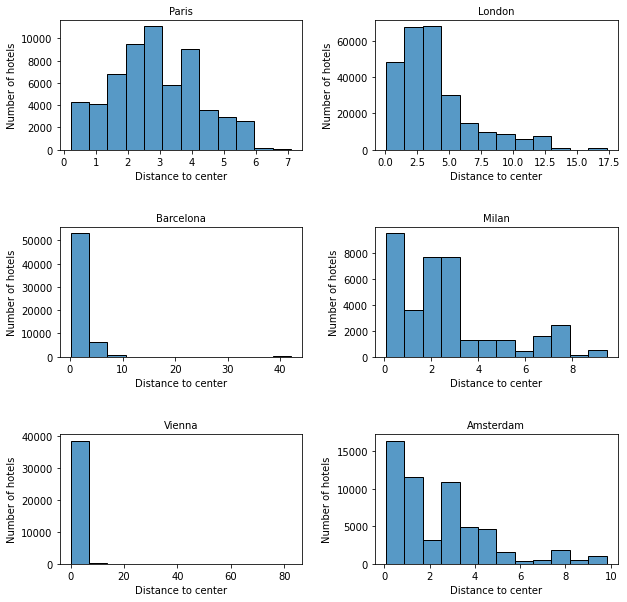

In [44]:
# посмотрим, как распределены отели от центра по городам
# обернем этот код в функцию, чтобы потом вызвать еще раз

def dist_histplot():
    bins_number = 12
    font = 10
    x_label = 'Distance to center'

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
    plt.subplots_adjust(hspace=.6, wspace=.3)

    histplot_par = sns.histplot(data=data[data.city == 'Paris'], 
                                x='distance', bins=bins_number, ax=axes[0,0])
    histplot_par.set_title('Paris', fontsize=font)
    histplot_par.set_xlabel(x_label)
    histplot_par.set_ylabel('Number of hotels')

    histplot_lon = sns.histplot(data=data[data.city == 'London'],
                                x='distance', bins=bins_number, ax=axes[0,1])
    histplot_lon.set_title('London', fontsize=font)
    histplot_lon.set_xlabel(x_label)
    histplot_lon.set_ylabel('Number of hotels')

    histplot_bar = sns.histplot(data=data[data.city == 'Barcelona'],
                                x='distance', bins=bins_number, ax=axes[1,0])
    histplot_bar.set_title('Barcelona', fontsize=font)
    histplot_bar.set_xlabel(x_label)
    histplot_bar.set_ylabel('Number of hotels')

    histplot_mil = sns.histplot(data=data[data.city == 'Milan'],
                                x='distance', bins=bins_number, ax=axes[1,1])
    histplot_mil.set_title('Milan', fontsize=font)
    histplot_mil.set_xlabel(x_label)
    histplot_mil.set_ylabel('Number of hotels')

    histplot_vie = sns.histplot(data=data[data.city == 'Vienna'],
                                x='distance', bins=bins_number, ax=axes[2,0])
    histplot_vie.set_title('Vienna', fontsize=font)
    histplot_vie.set_xlabel(x_label)
    histplot_vie.set_ylabel('Number of hotels')

    histplot_ams = sns.histplot(data=data[data.city == 'Amsterdam'],
                                x='distance', bins=bins_number, ax=axes[2,1])
    histplot_ams.set_title('Amsterdam', fontsize=font)
    histplot_ams.set_xlabel(x_label)
    histplot_ams.set_ylabel('Number of hotels');
    
    return None

dist_histplot()

Есть некоторые выбросы (Barcelona, Vienna). Посмотрим на них.

In [45]:
# найдем названия отелей, которые находятся за 20 км от города
mask = data['distance']>=20
data[mask]['hotel_name'].unique()

array(['NH Collection Barcelona Podium', 'Hotel Park Villa'], dtype=object)

In [46]:
data[mask][['hotel_name','hotel_address','country', 'lat', 'lng', 'distance']].head(10)

,hotel_name,hotel_address,country,lat,lng,distance
1285,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.396133,1.655829,42.089284
1911,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.396133,1.655829,42.089284
10949,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.396133,1.655829,42.089284
11348,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.396133,1.655829,42.089284
18875,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.396133,1.655829,42.089284
20938,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.778035,15.655650,82.552511
22052,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.778035,15.655650,82.552511
22894,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.778035,15.655650,82.552511
25089,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.396133,1.655829,42.089284
25602,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.778035,15.655650,82.552511


In [47]:
# посмотрим на их адреса
data[mask]['hotel_address'].unique()

array(['Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria'], dtype=object)

В датасете неправильные координаты и неправильно прогрузился адрес отелей

Адрес: Hotel Park Villa, 12, Hasenauerstraße, Cottageviertel, Upper Döbling, Дёблинг, Вена, 1190, Австрия
Широта: 48.233523
Долгота: 16.345655

Адрес: Carrer de Bailèn, la Dreta de l'Eixample, Эшампле, Барселона, Барселонес, Барселона, Каталония, 08001, Испания
Широта: 41.392935
Долгота: 2.175888

Исправим это вручную.

In [48]:
%%time
mask_hotel = data['hotel_name'] == 'Hotel Park Villa'
df_mask = data[mask&mask_hotel].index
data.loc[df_mask, 'lat'] = 48.233523
data.loc[df_mask, 'lng'] = 16.345655
data.loc[df_mask, 'distance'] = data.apply(lambda x:
                                  distance_to_center(x.city, x.lat, x.lng), 
                                  axis = 1)

mask_hotel = data['hotel_name'] == 'NH Collection Barcelona Podium'
df_mask = data[mask&mask_hotel].index
data.loc[df_mask, 'lat'] = 41.392935
data.loc[df_mask, 'lng'] = 2.175888
data.loc[df_mask, 'distance'] = data.apply(lambda x:
                                  distance_to_center(x.city, x.lat, x.lng), 
                                  axis = 1)

CPU times: user 6min 48s, sys: 738 ms, total: 6min 49s
Wall time: 6min 49s


In [49]:
# проверим, поправилось ли
data[data['hotel_name'] == 'NH Collection Barcelona Podium'][['hotel_name','hotel_address','country', 'lat', 'lng', 'distance']].head(10)

,hotel_name,hotel_address,country,lat,lng,distance
1285,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
1911,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
10949,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
11348,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
18875,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
25089,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
31125,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
39928,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
48745,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637
54214,NH Collection Barcelona Podium,Bail n 4 6 Eixample 08010 Barcelona Spain,Spain,41.392935,2.175888,1.48637


In [50]:
# проверка
data[data['hotel_name'] == 'Hotel Park Villa'][['hotel_name','hotel_address','country', 'lat', 'lng', 'distance']].head(10)

,hotel_name,hotel_address,country,lat,lng,distance
20938,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
22052,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
22894,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
25602,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
37606,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
39366,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
51138,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
76670,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
85159,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398
89751,Hotel Park Villa,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Austria,48.233523,16.345655,3.406398


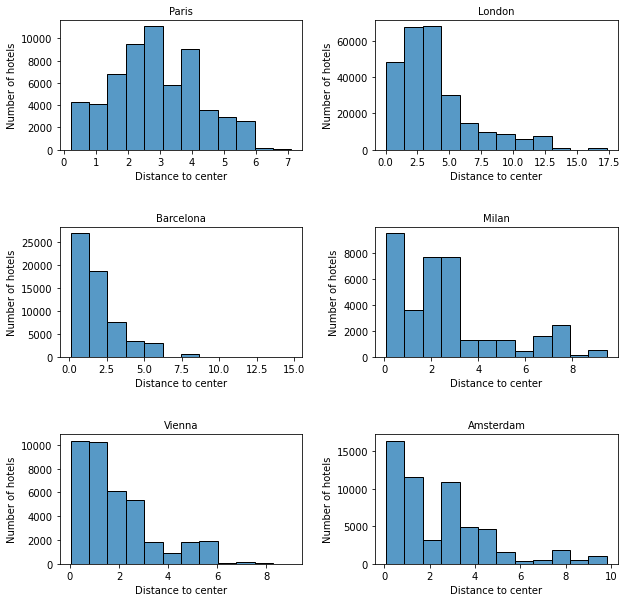

In [51]:
# посмотрим, как распределены отели от центра по городам теперь
dist_histplot()

Теперь стало намного лучше. Переходим к следующим признакам.

## 2) Признаки, связанные с ревьювером.
Посмотрим на признак национальность посетителя.

In [52]:
# анализ национальности посетителя
data['reviewer_nationality'].unique()

array([' United Kingdom ', ' Belgium ', ' Sweden ',
       ' United States of America ', ' Ecuador ', ' Netherlands ',
       ' Ireland ', ' Canada ', ' Norway ', ' Bulgaria ', ' Italy ',
       ' Australia ', ' Seychelles ', ' Kuwait ', ' Saudi Arabia ',
       ' Czech Republic ', ' France ', ' Germany ', ' South Africa ',
       ' United Arab Emirates ', ' Greece ', ' Spain ', ' Switzerland ',
       ' Macedonia ', ' Poland ', ' Bahrain ', ' Qatar ', ' India ',
       ' Singapore ', ' Malaysia ', ' Thailand ', ' Brazil ', ' Crimea ',
       ' Turkey ', ' Israel ', ' ', ' Lebanon ', ' Romania ', ' Cyprus ',
       ' Portugal ', ' Slovakia ', ' Jersey ', ' Gibraltar ', ' Austria ',
       ' Kenya ', ' Isle of Man ', ' Costa Rica ', ' Oman ', ' Hungary ',
       ' Iceland ', ' Estonia ', ' Hong Kong ', ' China ', ' Malta ',
       ' Pakistan ', ' Montenegro ', ' Slovenia ', ' South Korea ',
       ' Ukraine ', ' Japan ', ' Azerbaijan ', ' Russia ', ' Brunei ',
       ' Cayman Islands ',

Немного подправим представление данных, чтобы национальности были в таком же виде, как страны отеля (уберем лишние побелы).

In [53]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x : x.strip())
data['reviewer_nationality'].unique()            

array(['United Kingdom', 'Belgium', 'Sweden', 'United States of America',
       'Ecuador', 'Netherlands', 'Ireland', 'Canada', 'Norway',
       'Bulgaria', 'Italy', 'Australia', 'Seychelles', 'Kuwait',
       'Saudi Arabia', 'Czech Republic', 'France', 'Germany',
       'South Africa', 'United Arab Emirates', 'Greece', 'Spain',
       'Switzerland', 'Macedonia', 'Poland', 'Bahrain', 'Qatar', 'India',
       'Singapore', 'Malaysia', 'Thailand', 'Brazil', 'Crimea', 'Turkey',
       'Israel', '', 'Lebanon', 'Romania', 'Cyprus', 'Portugal',
       'Slovakia', 'Jersey', 'Gibraltar', 'Austria', 'Kenya',
       'Isle of Man', 'Costa Rica', 'Oman', 'Hungary', 'Iceland',
       'Estonia', 'Hong Kong', 'China', 'Malta', 'Pakistan', 'Montenegro',
       'Slovenia', 'South Korea', 'Ukraine', 'Japan', 'Azerbaijan',
       'Russia', 'Brunei', 'Cayman Islands', 'Serbia', 'Argentina',
       'Denmark', 'Egypt', 'Finland', 'Mexico', 'Taiwan', 'Peru',
       'Philippines', 'New Zealand', 'Luxembourg', 

Создадим новый признак - если национальность ревьювера совпадает со страной отеля, то заполним 1, если нет - 0.

In [54]:
data['local_reviewer'] = data.apply(lambda x : 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)
data[['reviewer_nationality','country','local_reviewer']].head(10)

,reviewer_nationality,country,local_reviewer
0,United Kingdom,Italy,0
1,Belgium,Netherlands,0
2,Sweden,Spain,0
3,United States of America,Italy,0
4,United Kingdom,Netherlands,0
5,Ecuador,United Kingdom,0
6,United Kingdom,United Kingdom,1
7,Netherlands,United Kingdom,0
8,Ireland,France,0
9,Canada,United Kingdom,0


In [55]:
# посмотрим, сколько всего уникальных национальностей ревьюверов
data['reviewer_nationality'].nunique()

227

In [ ]:
# оставляем 10 популярных национальностей ревьюверов
#popular_nationality = data['reviewer_nationality'].value_counts().nlargest(10).index
#data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')

In [ ]:
# статистическая информация в разрезе национальности ревьюверов
#data[data['sample']==1].groupby('reviewer_nationality')['reviewer_score'].describe()

Урезание количества национальностей увеличивает метрику. Национальностей не так много, можно будет закодировать бинарным способом.

Далее посмотрим на признак tags и разберем его на составляющие.

In [56]:
# посмотрим на теги
print(data['tags'].iloc[56])
print(data['tags'].iloc[2556])
print(data['tags'].iloc[42556])
print(data['tags'].iloc[20056])
print(data['tags'].iloc[556])
print(data['tags'].iloc[34578])
print(data['tags'].iloc[40054])
print(data['tags'].iloc[75823])

[' Leisure trip ', ' Family with young children ', ' Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Solo traveler ', ' Deluxe Single Room ', ' Stayed 7 nights ']
[' Leisure trip ', ' Family with older children ', ' Room with Ramblas View ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Signature Luxury King with Balcony ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Couple ', ' Deluxe Studio ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Family with older children ', ' Classic Triple Room ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Group ', ' Standard Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Group ', ' Double or Twin Room ', ' Stayed 2 nights ']


In [57]:
# преобразуем тэги в списки, посчитаем макс кол-во тегов
# добавляю новый признак tags_del, буду из него удалять отработанные теги

data['tags_del'] = data['tags'].apply(lambda x: x[1:] if x[0] == '[' else x)
data['tags_del'] = data['tags_del'].apply(lambda x: x[:-1] if x[-1] == ']' else x)

data['tags_del'] = data['tags_del'].apply(lambda x: x.replace('\' ', ''))
data['tags_del'] = data['tags_del'].apply(lambda x: x.replace(' \'', ''))

data['tags_del'] = data['tags_del'].apply(lambda x: x.strip().split(', '))

data['tags_count'] = data['tags_del'].apply(len)

data['tags_count'].value_counts()

5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: tags_count, dtype: int64

In [58]:
# посмотрим на те, у которых макс число тегов 6
mask = data['tags_count'] == 6

print(data[mask]['tags'].iloc[1])
print(data[mask]['tags'].iloc[28])
print(data[mask]['tags'].iloc[156])
print(data[mask]['tags'].iloc[459])

[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Duplex Suite with Spa Access ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Business trip ', ' Solo traveler ', ' Double or Twin Room 1 2 Adults ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' 4 Person Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']


In [59]:
# Создаем новую колонку with_pet

def with_pet(arg):
    ''' Функция ищет конкретное значение в строке и возвращает 1, 
    если значение найдено, в противном случае возвращает 0'''
    
    res = 0
    for element in arg:
        if 'With a pet' in element:
            res = 1
            arg.remove(element)
            
    return res

data['with_pet'] = data['tags_del'].apply(with_pet)
#посмотрим, сколько ревьюверов было с домашними питомцами
data['with_pet'].value_counts()

0    514333
1      1405
Name: with_pet, dtype: int64

In [60]:
# обрабатываем  Business trip и Leisure trip
def type_trip(arg):
    
    ''' Функция ищет конкретное значение в строке и возвращает тип путешествия
    (бизнес или отдых), если значение найдено, в противном случае возвращает Unknown'''
    
    res = 'Unknown'
    for element in arg:
        if 'Business trip' in element:
            res = 'Business trip'
            arg.remove(element)
            
        if 'Leisure trip' in element:
            res = 'Leisure trip'
            arg.remove(element)
            
    return res

data['type_trip'] = data['tags_del'].apply(type_trip)

data['type_trip'].value_counts()

Leisure trip     417778
Business trip     82939
Unknown           15021
Name: type_trip, dtype: int64

In [61]:
# Обрабатываем Submitted from a mobile device
def mobile_device(arg):
    ''' Функция ищет конкретное значение в строке и возвращает 1,
    если значение найдено, в противном случае возвращает 0 '''
       
    res = 0
    for element in arg:
        if 'Submitted from a mobile device' in element:
            res = 1
            arg.remove(element)
            
    return res

data['mobile'] = data['tags_del'].apply(mobile_device)
data['mobile'].value_counts()

1    307640
0    208098
Name: mobile, dtype: int64

In [62]:
# Обрабатываем на сколько ночей оставались посетители
def count_nights(arg):
    
    ''' Функция ищет конкретное значение в строке и возвращает число 
    (количество дней, проведенных в отеле), если значение найдено, в противном случае возвращает 0 '''
    
    res = 0
    for element in arg:
        if 'Stayed' in element:
            res = element.split(' ')[1]
            arg.remove(element)
            
    return res

data['count_nights'] = data['tags_del'].apply(count_nights).astype(np.int16)
data['count_nights'].value_counts()

1     193645
2     133937
3      95821
4      47817
5      20845
6       9776
7       7399
8       2502
9       1293
10       889
11       418
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: count_nights, dtype: int64

In [63]:
# обрабатываем в каком составе путешествовали Solo, Couple, Family with young children, 
# Family with older children, Travelers with friends или Group

def travelers(arg):
    
    ''' Функция ищет конкретное значение в строке и возвращает в каком составе путешествовали,
    если значение найдено, в противном случае возвращает Unknown '''
    
    res = 'Unknown'
    for element in arg:
        if 'Solo traveler' in element:
            res = 'Solo traveler'
            arg.remove(element)
            
        if 'Family with young children' in element:
            res = 'Family with young children'
            arg.remove(element)
        
        if 'Group' in element:
            res = 'Group'
            arg.remove(element)
            
        if 'Couple' in element:
            res = 'Couple'
            arg.remove(element)
        
        if 'Family with older children' in element:
            res = 'Family with older children'
            arg.remove(element)
        
        if 'Travelers with friends' in element:
            res = 'Travelers with friends'
            arg.remove(element)            
            
    return res

data['travelers'] = data['tags_del'].apply(travelers)
data['travelers'].value_counts()

Couple                        252294
Solo traveler                 108545
Group                          65392
Family with young children     61015
Family with older children     26349
Travelers with friends          2143
Name: travelers, dtype: int64

In [64]:
# Обрабатываем тип комнаты
def rooms(arg):
    
    ''' Функция ищет конкретное значение в строке и возвращает тип комнаты,
    если значение найдено, в противном случае возвращает Unknown '''
    
    res = 'Unknown'
    for element in arg:
        res = element
        arg.remove(element)
            
    return res

data['room'] = data['tags_del'].apply(rooms)
data['room'].value_counts()

Double Room                               35207
Standard Double Room                      32248
Superior Double Room                      31393
Deluxe Double Room                        24823
Double or Twin Room                       22393
                                          ...  
Superior Suite Water Front                    1
Suite Aurore                                  1
Deluxe Family Room 2 Adults 2 Children        1
Executive Suite 1 King                        1
Quadruple Room 2 Adults 2 Children            1
Name: room, Length: 2388, dtype: int64

In [65]:
#посмотрим, сколько всего названий комнат
data['room'].nunique()

2388

In [ ]:
# берем 100 популярных комнат, остальные будут other
#popular_rooms = data['room'].value_counts().nlargest(100).index
#data['room'] = data['room'].apply(lambda x: x if x in popular_rooms else 'other')

Урезать количество комнат также не буду, ухудшается метрика.

In [66]:
# удаляем уже ненужные признаки
data = data.drop(columns=['tags_del','tags_count' ], axis=1)

In [67]:
# преобразовываем признак days_since_review в int, убираем слово, оставляем число
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.strip().split(' ')[0]).astype(np.int16)
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int16

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## 3) Признаки, связанные с отзывами.

Сначала рассмотрим дату отзыва. Этот признак ранее уже перевели в тип ДатаВремя. Теперь на его основе создадим еще несколько признаков.

In [69]:
#теперь создадим новые признаки - месяц, год, день недели, время года

data['review_month'] = data['review_date'].dt.month
data['review_year'] = data['review_date'].dt.year
data['review_weekday'] = data['review_date'].dt.dayofweek
data['season'] = data['review_month'].apply(lambda x: 1 if x in (12, 1, 2) 
                                        else (2 if x in (3, 4, 5)
                                              else (3 if x in (6, 7, 8)
                                                    else 4)))

In [70]:
data[['season','review_month']]

,season,review_month
0,3,7
1,1,12
2,4,11
3,4,10
4,2,5
...,...,...
515733,2,4
515734,1,2
515735,1,2
515736,2,5


review_month
1     8.482245
2     8.534773
3     8.481505
4     8.432322
5     8.385711
6     8.387010
7     8.339102
8     8.412986
9     8.293349
10    8.262119
11    8.343183
12    8.431444
Name: reviewer_score, dtype: float64

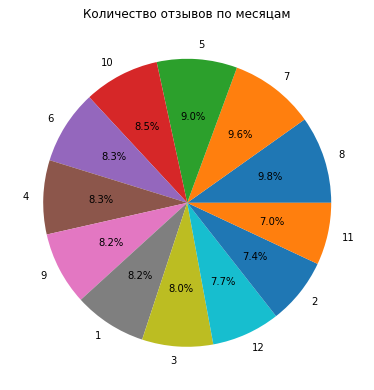

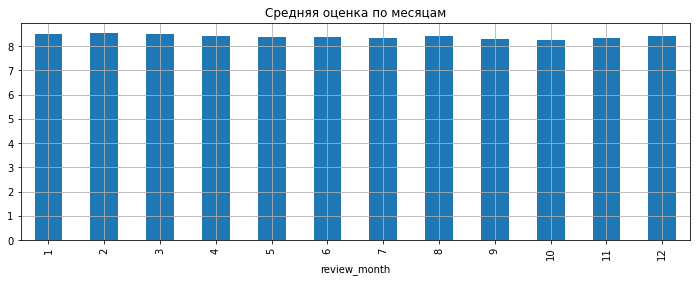

In [71]:
count_review_month = data['review_month'].value_counts()
sum_review_month = data[data['sample']==1].groupby('review_month')['reviewer_score'].mean()


fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    count_review_month,
    labels=count_review_month.index,

    autopct='%.1f%%'
);
axes.set_title("Количество отзывов по месяцам");

fig = plt.figure(figsize=(5, 5))
sum_review_month.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    title = "Средняя оценка по месяцам"
);
sum_review_month

Больше всего отзывов было оставлено в августе, меньше всего в ноябре. Средние оценки отличаются друг от друга незначительно.

review_year
2015    8.323993
2016    8.424856
2017    8.393787
Name: reviewer_score, dtype: float64

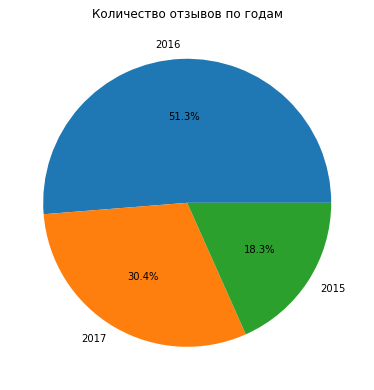

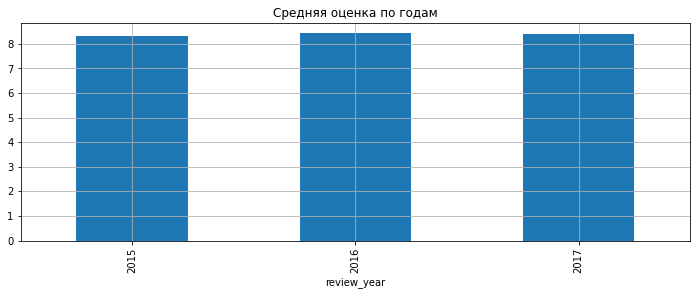

In [72]:
count_review_year = data['review_year'].value_counts()
sum_review_year = data[data['sample']==1].groupby('review_year')['reviewer_score'].mean()


fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    count_review_year,
    labels=count_review_year.index,

    autopct='%.1f%%'
);
axes.set_title("Количество отзывов по годам");

fig = plt.figure(figsize=(5, 5))
sum_review_year.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    title = "Средняя оценка по годам"
);
sum_review_year

Меньше всего представлено отзывов за 2015, больше всего за 2016 год, что логично, т.к. за 2015 год  выгружены отзывы с августа по декабрь, а 2016 год - за все 12 месяцев. По средней оценке различий почти нет.

review_weekday
0    8.394442
1    8.444557
2    8.408968
3    8.347063
4    8.370422
5    8.370156
6    8.396875
Name: reviewer_score, dtype: float64

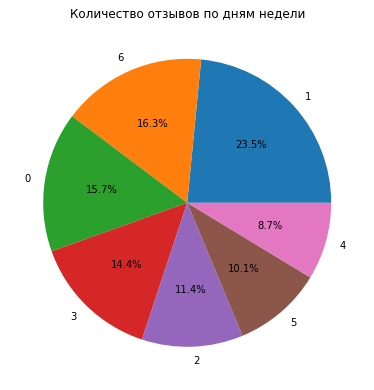

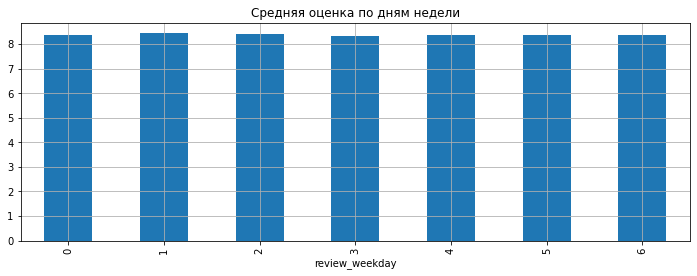

In [73]:
count_review_weekday = data['review_weekday'].value_counts()
sum_review_weekday = data[data['sample']==1].groupby('review_weekday')['reviewer_score'].mean()


fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    count_review_weekday,
    labels=count_review_weekday.index,

    autopct='%.1f%%'
);
axes.set_title("Количество отзывов по дням недели");

fig = plt.figure(figsize=(5, 5))
sum_review_weekday.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    title = "Средняя оценка по дням недели"
);
sum_review_weekday

Больше всего отзывов было оставлено во вторник, меньше всего - в пятницу. Средние оценки отличаются незначительно. Самая высокая средняя оценка во вторник, самая низкая - в четверг.

season
1    8.482244
2    8.431332
3    8.379603
4    8.296789
Name: reviewer_score, dtype: float64

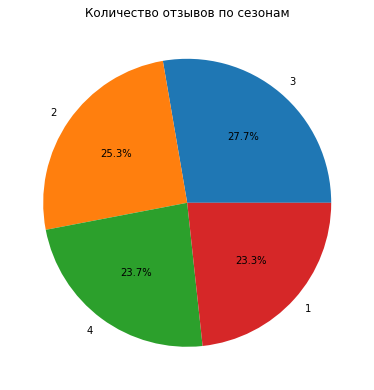

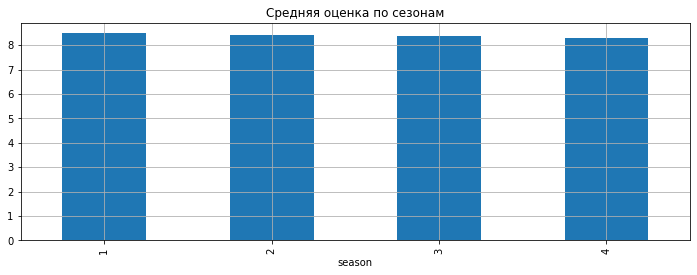

In [74]:
count_review_seasons = data['season'].value_counts()
sum_review_seasons = data[data['sample']==1].groupby('season')['reviewer_score'].mean()


fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    count_review_seasons,
    labels=count_review_seasons.index,

    autopct='%.1f%%'
);
axes.set_title("Количество отзывов по сезонам");

fig = plt.figure(figsize=(5, 5))
sum_review_seasons.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    title = "Средняя оценка по сезонам"
);
sum_review_seasons

Летом отзывов больше, а средняя оценка выше зимой.

Переходим к самим отзывам.

In [75]:
# посмотрим на негативные отзывы
data[['negative_review','review_total_negative_word_counts']]

,negative_review,review_total_negative_word_counts
0,Would have appreciated a shop in the hotel th...,52
1,No tissue paper box was present at the room,10
2,Pillows,3
3,No Negative,0
4,No Negative,0
...,...,...
515733,No Negative,0
515734,No Negative,0
515735,room is really small but guess is normal in L...,12
515736,No Negative,0


In [76]:
# заменяем в негативном отзыве некоторые слова, чтобы сентиментальный анализ был более точным
data.negative_review.replace({'Nothing': 'Good',
                             'nothing': 'Good',
                             'No positive': 'Bad',
                             'No negative comments':'Perfect',
                             'Everything nothing I disliked':'Perfect', 
                             'None' : 'Neutral',
                             'Nothing to dislike':'Good',
                             'Nothing all excellent': 'Excellent',
                             'No negative comments': 'Perfect',
                             'No' : 'Neutral',
                             'Nothing at all' : 'Good', 
                             'Nothing really' : 'Good', 
                             'Non' : 'Neutral',
                             'Not applicable' : 'Neutral', 
                             'Nothing in particular' : 'Neutral',
                             'There was nothing i didn t like' : 'Good', 
                             'Nothing comes to mind' : 'Good', 
                             'Not a thing':'Good',
                             'No thing' : 'Good',
                             'No bad experience' : 'Neutral',
                             'No bad experiences' : 'Neutral',
                             'No Negative' : 'Good',
                             'No dislikes' : 'Good',
                             'No thanks' : 'Neutral',
                             'No complaints' : 'Good',
                             'All': 'Bad',
                             'Everything': 'Bad',
                             'Nothing smarties everyday':'Perfect',
                             'Nothing it was lovely':'Perfect'
  }, inplace = True)

In [77]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [78]:
%%time

# добавим новые признаки, в которые загрузим результаты сентиментального анализа
data['neg_neg'] = 0.0
data['neg_neu'] = 0.0
data['neg_pos'] = 0.0
data['neg_compound'] = 0.0

def fill_score(arg, review, param):
    
    '''Функция обрабатывает текст - проводит сентиментальный анализ 
    и возвращает оценку этого анализа'''
    
    review_scores = sent_analyzer.polarity_scores(arg[review])
    
    arg[param+'_neg'] = review_scores['neg'] 
    arg[param+'_neu'] = review_scores['neu']
    arg[param+'_pos'] = review_scores['pos']
    arg[param+'_compound'] = review_scores['compound']
    
    return arg            

data = data.apply(lambda x: fill_score(x, 'negative_review', 'neg'), axis=1) 

data[['negative_review', 'neg_neg', 'neg_neu','neg_pos','neg_compound']].head(20)

CPU times: user 4min 33s, sys: 3.46 s, total: 4min 36s
Wall time: 4min 36s


,negative_review,neg_neg,neg_neu,neg_pos,neg_compound
0,Would have appreciated a shop in the hotel th...,0.129,0.747,0.125,-0.0554
1,No tissue paper box was present at the room,0.216,0.784,0.000,-0.2960
2,Pillows,0.000,1.000,0.000,0.0000
3,Good,0.000,0.000,1.000,0.4404
4,Good,0.000,0.000,1.000,0.4404
5,They don t have free wifi,0.000,0.548,0.452,0.5106
6,Room generally a bit shabby with some lack of...,0.066,0.855,0.080,0.1280
7,Executive rooms 9th Floor don t have a bath T...,0.045,0.830,0.126,0.6124
8,Pity about the two days of rain,0.268,0.732,0.000,-0.2960
9,Didn t like it at all construction was in pro...,0.131,0.603,0.266,0.4019


In [79]:
# посмотрим на позитивные отзывы
data[['positive_review','review_total_positive_word_counts']]

,positive_review,review_total_positive_word_counts
0,Hotel was great clean friendly staff free bre...,62
1,No Positive,0
2,Nice welcoming and service,5
3,Everything including the nice upgrade The Hot...,27
4,Lovely hotel v welcoming staff,7
...,...,...
515733,Tr s proche du metro Earl s court,10
515734,The bed was so comfy I stayed with my boyfrie...,93
515735,great location simple check in out nice shower,9
515736,Location and very comfy bed,6


In [80]:
%%time
# добавим новые признаки, в которые загрузим результаты сентиментального анализа
data['pos_neg'] = 0.0
data['pos_neu'] = 0.0
data['pos_pos'] = 0.0
data['pos_compound'] = 0.0 

data.positive_review.replace({'No Positive': 'Neutral',
                            'Nothing': 'Terrible',
                            'Nothings': 'Terrible',
                            'Everything':'Perfect',
                            'All': 'Perfect',
                            'no': 'Neutral',
                            'X':'Terrible',
                             'Almost nothing':'Bad'
                           }, inplace = True)

data = data.apply(lambda x: fill_score(x, 'positive_review', 'pos'), axis=1) 

data[['positive_review', 'pos_neg', 'pos_neu','pos_pos','pos_compound']].head(20)

CPU times: user 4min 42s, sys: 3.28 s, total: 4min 46s
Wall time: 4min 46s


,positive_review,pos_neg,pos_neu,pos_pos,pos_compound
0,Hotel was great clean friendly staff free bre...,0.000,0.671,0.329,0.9615
1,Neutral,0.000,1.000,0.000,0.0000
2,Nice welcoming and service,0.000,0.260,0.740,0.6908
3,Everything including the nice upgrade The Hot...,0.000,0.621,0.379,0.9153
4,Lovely hotel v welcoming staff,0.000,0.230,0.770,0.7717
5,The location is perfect if you don t have a l...,0.000,0.792,0.208,0.6124
6,Location price It did not cost much more to h...,0.000,0.852,0.148,0.5106
7,Comphy bed upgraded to executive room with ne...,0.050,0.814,0.136,0.5859
8,Its centrality proximity to our destination,0.000,1.000,0.000,0.0000
9,Didn t like anything about the stay if i had ...,0.089,0.711,0.200,0.3612


У нас есть еще такие признаки, как количество слов в негативном/позитивном отзывах. Попробуем добавить разницу количества слов в позитивной и негативной частях отзыва (предварительно нормализуем обе шкалы).


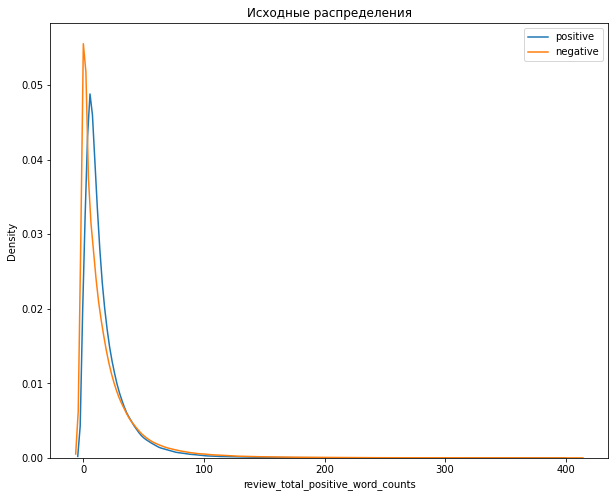

In [81]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

sns.kdeplot(data['review_total_positive_word_counts'], ax=ax1, label ='positive')
sns.kdeplot(data['review_total_negative_word_counts'], ax=ax1, label ='negative')

plt.legend()

In [82]:
# для нормализации, стандартизации
from sklearn import preprocessing

r_scaler = preprocessing.RobustScaler()

data['positive_word_count_norm']  = pd.DataFrame(
    r_scaler.fit_transform(pd.DataFrame(data['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

data['negative_word_count_norm']  = pd.DataFrame(
    r_scaler.fit_transform(pd.DataFrame(data['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# соединим эти показатели в один, отрицательные слова - с отрицательным коэффициентом:
data['total_word_diff_norm'] = data['positive_word_count_norm'] - data['negative_word_count_norm']

# а также добавим флаг - преобладают ли позитивные слова над негативными 
# в размерностях соответствующих диапазонов:
data['positive_more'] = data['total_word_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0)

In [83]:
data[['positive_word_count_norm','negative_word_count_norm','total_word_diff_norm', 'positive_more']].head(40)

,positive_word_count_norm,negative_word_count_norm,total_word_diff_norm,positive_more
0,3.000000,2.047619,0.952381,1
1,-0.647059,0.047619,-0.694678,0
2,-0.352941,-0.285714,-0.067227,0
3,0.941176,-0.428571,1.369748,1
4,-0.235294,-0.428571,0.193277,1
5,0.882353,-0.095238,0.977591,1
6,0.705882,1.238095,-0.532213,0
7,1.823529,2.047619,-0.224090,0
8,-0.235294,-0.047619,-0.187675,0
9,0.823529,0.428571,0.394958,1


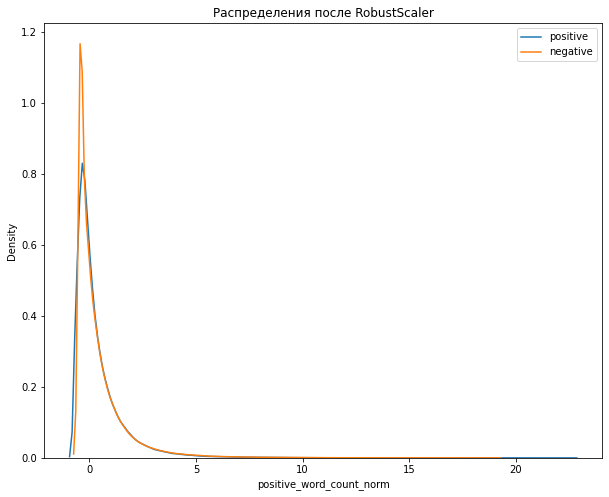

In [84]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(data['positive_word_count_norm'], ax=ax1, label ='positive')
sns.kdeplot(data['negative_word_count_norm'], ax=ax1, label ='negative')

plt.legend()

In [85]:
data.drop(['review_total_positive_word_counts', 
         'review_total_negative_word_counts'
          ], axis=1, inplace=True)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

## **4. Кодирование признаков**

У нас есть признаки типа object, которые нужно либо удалить, либо преобразовать к машинному типу - закодировать.

In [87]:
%%time
# применим однократное кодирование к тем категориальным признакам, количество
# значений которых не превышает 15
data = pd.get_dummies(data, columns=['city','travelers'])
data = pd.get_dummies(data, columns=['review_month','season','review_weekday'])

## применим двоичное кодирование к тем категориальным признакам, количество
# значений которых превышает 15
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality', 'room', 'hotel_name']) 
type_bin = bin_encoder.fit_transform(data[['reviewer_nationality', 'room', 'hotel_name']])
data = pd.concat([data, type_bin], axis=1)

# некоторые просто приведем к булевому виду 
data['for_business'] = data['type_trip'].apply(lambda x: 1 if x == 'Business trip' else 0)
data['for_leisure'] = data['type_trip'].apply(lambda x: 1 if x == 'Leisure trip' else 0)

#остальные удаляем
data.drop(['type_trip', 
         'hotel_address',
         'hotel_name',
         'negative_review',
         'positive_review',
         'tags',
         'country',
         'review_date',
         'reviewer_nationality',
         'room'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 95 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   total_number_of_reviews                     515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   distance                                    515738 non-null  float64
 

## **5. Отбор признаков**

Построим матрицу корреляций.

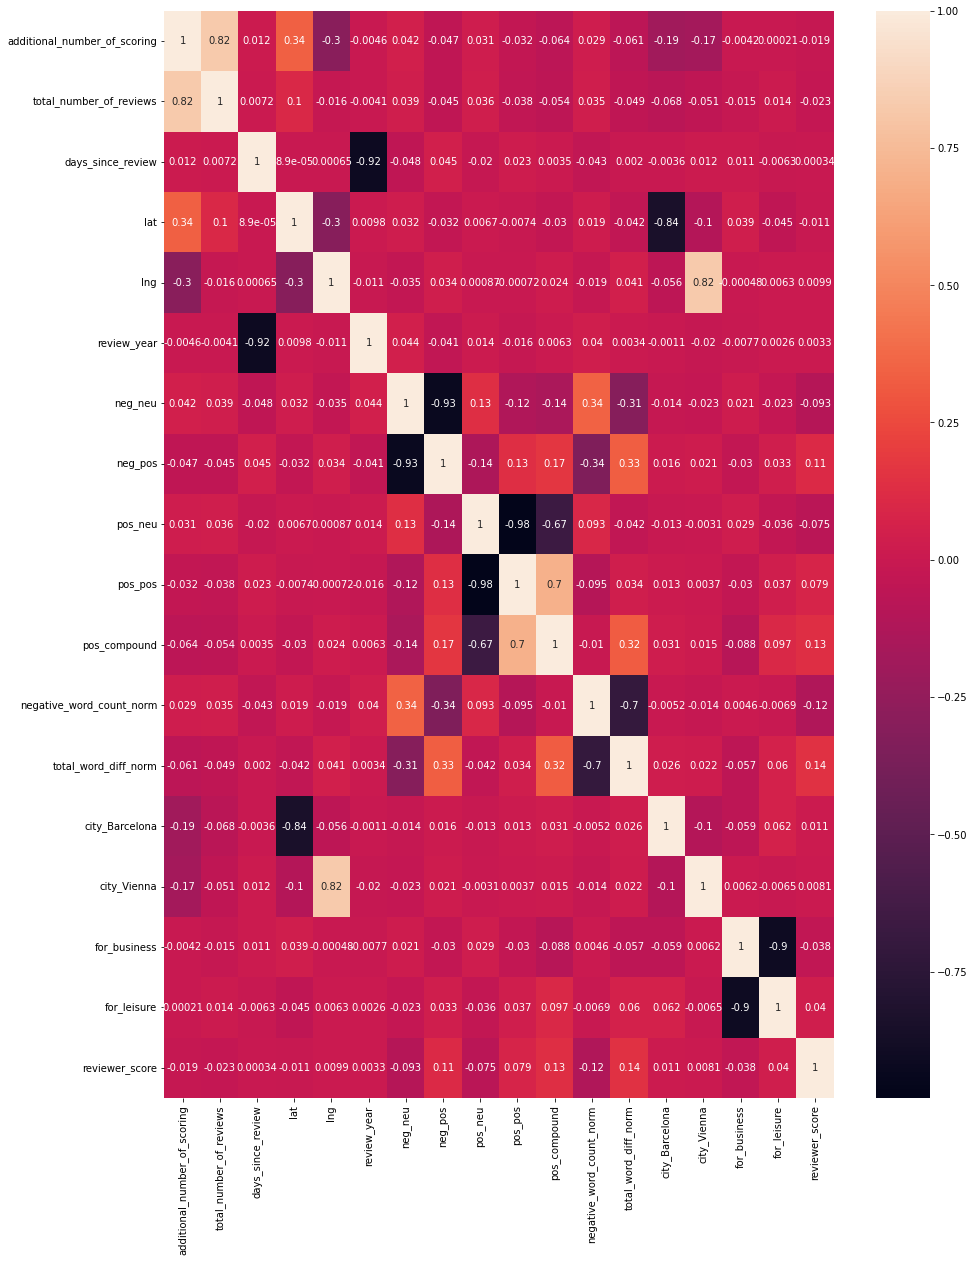

In [88]:
def matrix():
    
    ''' Функция строит матрицу корреляций, выводит на экран только те признаки,
    в которых наблюдается мультиколлинеарность'''
    
    df_corr = data.drop(['sample'], axis=1).corr()
    result_columns = []
    for column in df_corr:
        col_data = df_corr[column]
        if col_data.min() < -0.7 or col_data.sort_values(ascending=False)[1] > 0.7:
            result_columns.append(column)
    result_columns.append('reviewer_score')

    plt.rcParams['figure.figsize'] = (15,20)
    sns.heatmap(data[result_columns].corr(), annot=True)
    
    return None

matrix()

In [89]:
# поля с характеристиками отзывов оставлю и поля про тип поездки, остальное убираю
data.drop(['lat',
         'lng',
         'days_since_review',
         'total_number_of_reviews'], axis=1, inplace=True)

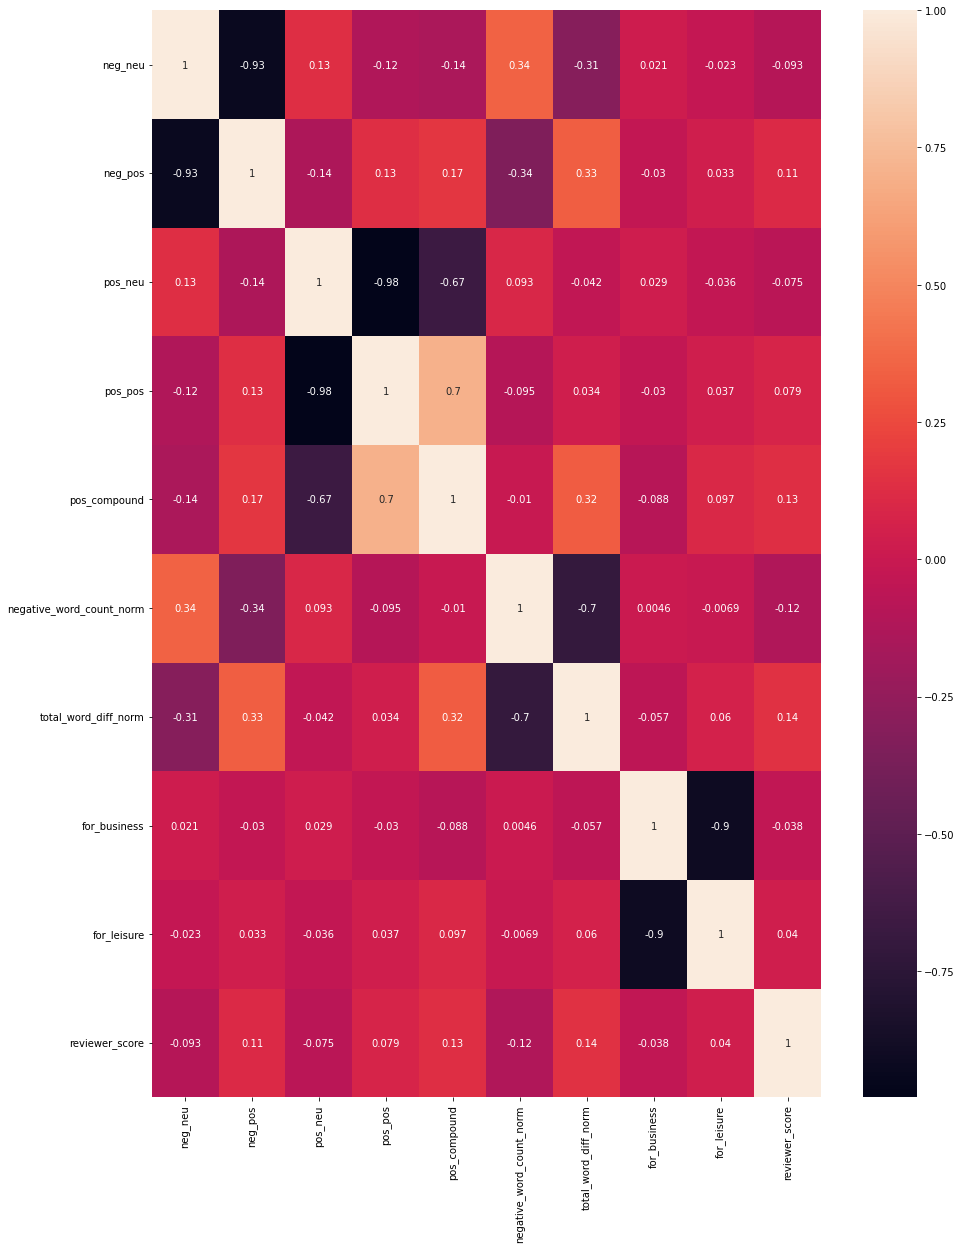

In [90]:
matrix()

In [91]:
#Проведем оценку значимости признаков
# Категориальные 
cat_cols = ['with_pet',
            'mobile',
            'count_nights',
            'review_year',
            'local_reviewer',
            'city_Amsterdam',
            'city_Barcelona',
            'city_London',
            'city_Milan',
            'city_Paris',
            'city_Vienna',
            'travelers_Couple',
            'travelers_Family with older children',
            'travelers_Family with young children',
            'travelers_Group',
            'travelers_Solo traveler',
            'travelers_Travelers with friends',
            'reviewer_nationality_0',
            'reviewer_nationality_1',
            'reviewer_nationality_2', 
            'reviewer_nationality_3',
            'reviewer_nationality_4', 
            'reviewer_nationality_5',
            'reviewer_nationality_6', 
            'reviewer_nationality_7', 
            'room_0', 
            'room_1',
            'room_2',
            'room_3', 
            'room_4', 
            'room_5', 
            'room_6', 
            'room_7',
            'room_8',
            'room_9', 
            'room_10',
            'room_11',
            'hotel_name_0',
            'hotel_name_1',
            'hotel_name_2',
            'hotel_name_3',
            'hotel_name_4',
            'hotel_name_5',
            'hotel_name_6', 
            'hotel_name_7',
            'hotel_name_8',
            'hotel_name_9',
            'hotel_name_10', 
            'for_business', 
            'for_leisure',
           'review_month_1',
       'review_month_2', 'review_month_3', 'review_month_4', 'review_month_5',
       'review_month_6', 'review_month_7', 'review_month_8', 'review_month_9',
       'review_month_10', 'review_month_11', 'review_month_12', 'season_1',
       'season_2', 'season_3', 'season_4', 'review_weekday_0',
       'review_weekday_1', 'review_weekday_2', 'review_weekday_3',
       'review_weekday_4', 'review_weekday_5', 'review_weekday_6'
           ]

# непрерывные признаки
num_cols = ['additional_number_of_scoring',
 'average_score',
 'distance',
 'neg_compound',
 'neg_neg',
 'neg_neu',
 'neg_pos',
 'pos_compound',
 'pos_neg',
 'pos_neu',
 'pos_pos',
 'negative_word_count_norm',
 'positive_word_count_norm', 
 'total_number_of_reviews_reviewer_has_given']


<AxesSubplot:>

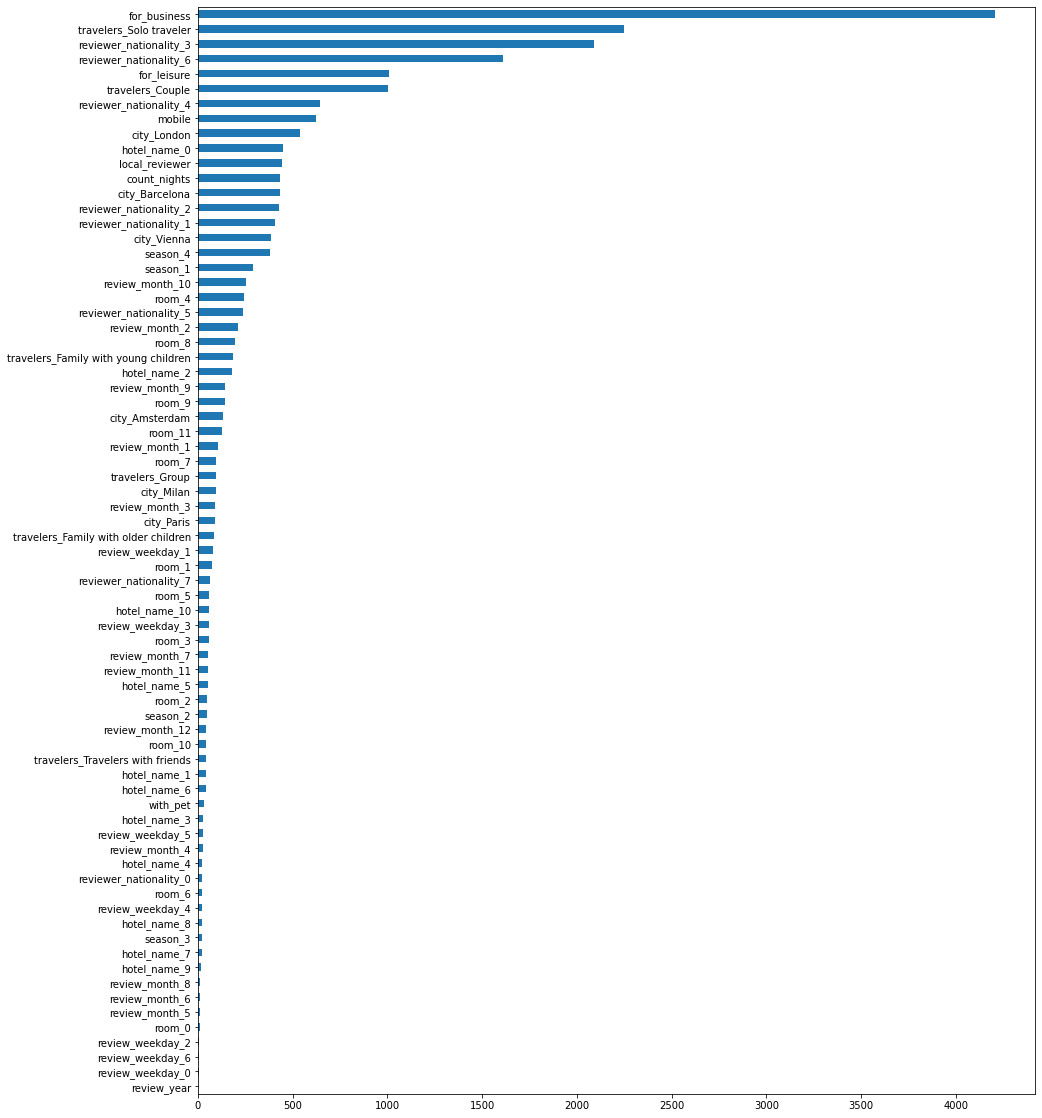

In [92]:
# посмотрим категориальные признаки. Применим тест Xи-квадрат
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)
y=y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))

imp_cat.plot(kind = 'barh')


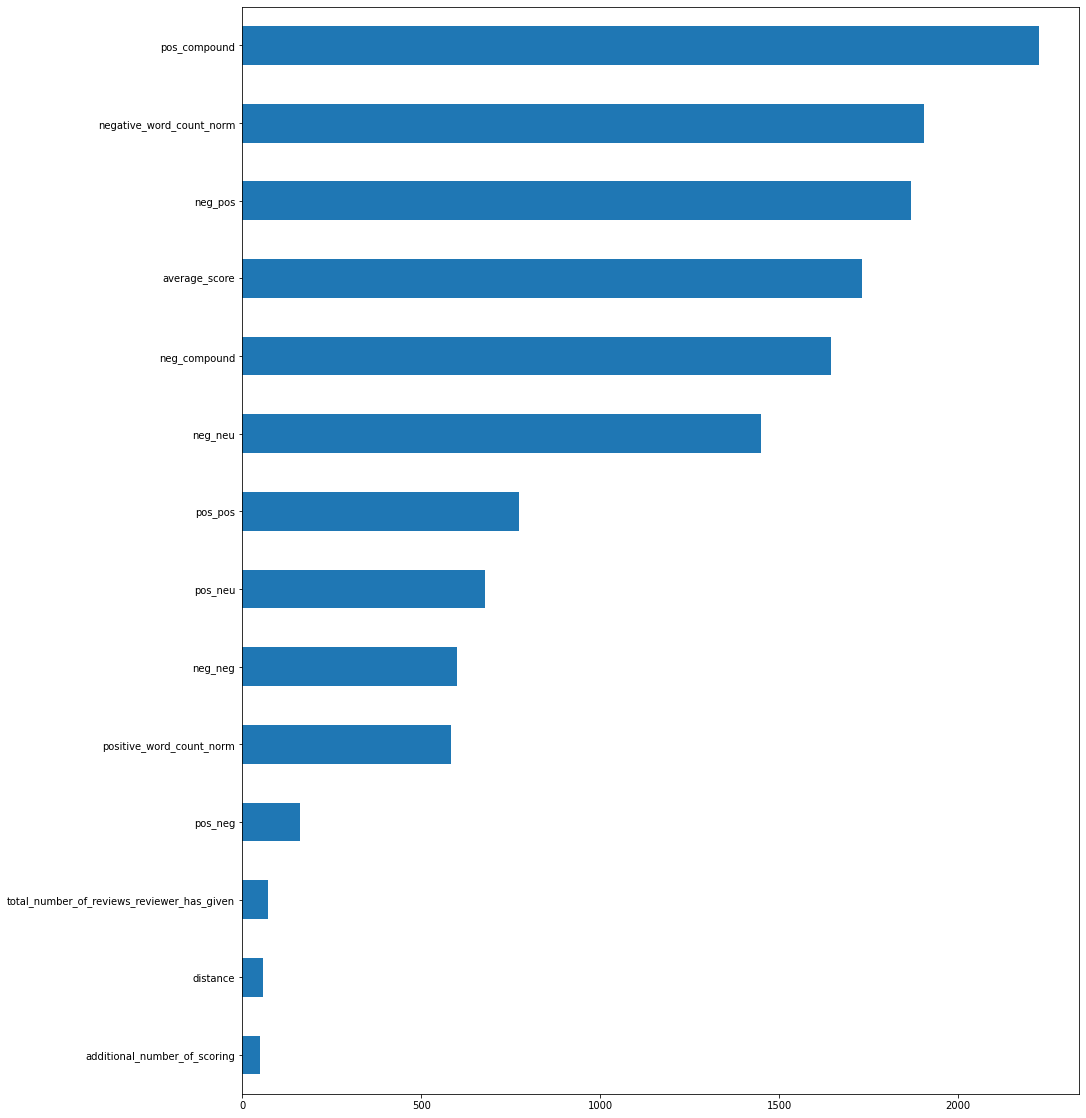

In [93]:
# посмотрим непрерывные числовые признаки. Применим тест ANOVA:

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh');

In [94]:
# удалим слабые признаки
data.drop(['review_weekday_2',
         'review_weekday_6',
         'review_weekday_0',
        'review_year'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 87 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 3   sample                                      515738 non-null  int64  
 4   reviewer_score                              515738 non-null  float64
 5   distance                                    515738 non-null  float64
 6   local_reviewer                              515738 non-null  int64  
 7   with_pet                                    515738 non-null  int64  
 8   mobile                                      515738 non-null  int64  
 9   count_nights                                515738 non-null  int64  
 

Данные подготовлены для обучения.

## **6. Обучение модели**

In [95]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [96]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [97]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 86), (386803, 86), (386803, 85), (309442, 85), (77361, 85))

In [98]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [99]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, 
                              verbose=1, 
                              n_jobs=-1, 
                              random_state=RANDOM_SEED)

In [100]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: user 21min, sys: 3.09 s, total: 21min 3s
Wall time: 5min 22s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [101]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8762391006050173


<AxesSubplot:>

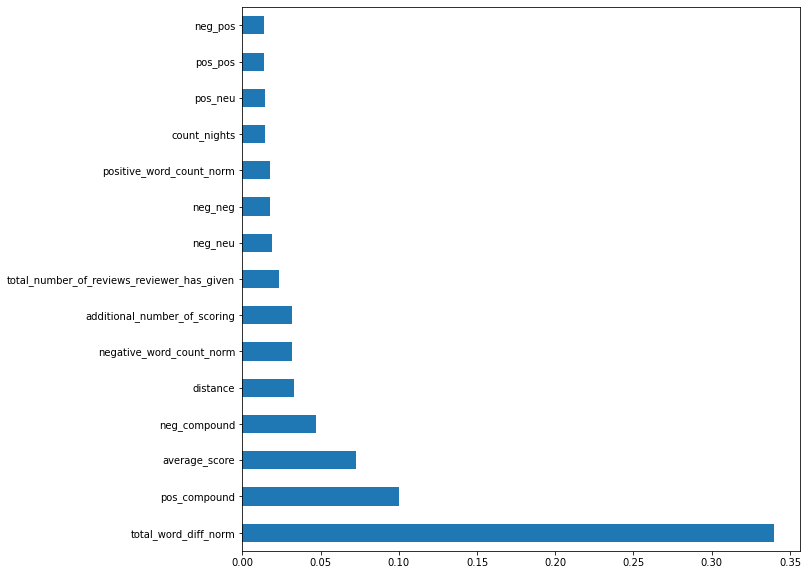

In [102]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [103]:
test_data.sample(10)

,additional_number_of_scoring,average_score,total_number_of_reviews_reviewer_has_given,reviewer_score,distance,local_reviewer,with_pet,mobile,count_nights,neg_neg,...,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,for_business,for_leisure
10856,69,9.0,15,0.0,1.866638,0,0,0,3,0.000,...,1,0,1,1,1,0,0,1,0,1
77282,1322,8.4,10,0.0,1.041991,0,0,1,2,0.000,...,0,1,0,1,1,0,0,0,1,0
91719,78,8.7,1,0.0,0.249434,0,0,1,3,0.524,...,1,0,0,0,0,0,0,1,0,1
103980,926,8.2,1,0.0,3.174744,0,0,1,2,0.000,...,1,1,1,0,0,0,0,1,0,1
75809,235,9.3,12,0.0,2.952629,1,0,1,1,0.000,...,1,0,1,1,1,0,0,1,0,1
90542,459,8.4,5,0.0,4.510068,1,0,1,1,0.000,...,0,0,1,1,1,0,0,1,0,0
78451,227,6.9,1,0.0,16.845769,1,0,1,1,0.127,...,0,1,0,0,1,1,1,0,0,1
96542,832,8.9,8,0.0,12.121455,0,0,1,4,0.000,...,1,0,1,0,0,1,0,1,1,0
90765,550,8.8,6,0.0,1.216012,0,0,1,5,0.237,...,0,0,1,0,1,0,1,0,0,1
80923,1936,8.7,1,0.0,3.320326,1,0,0,2,0.000,...,0,0,1,0,0,1,1,0,0,1


In [104]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [105]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [106]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [107]:
predict_submission

array([8.767, 7.432, 8.386, ..., 7.835, 9.606, 7.163])

In [108]:
list(sample_submission)

['reviewer_score', 'id']

In [109]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.767,488440
1,7.432,274649
2,8.386,374688
3,9.698,404352
4,9.600,451596
5,8.844,302161
6,7.799,317079
7,7.590,13963
8,8.348,159785
9,7.754,195089


## **7. Заключение**


В рамках данного проекта нужно было создать свою первую модель, основанную на алгоритмах машинного обучения.
И чтобы модель заработала, в неё нужно было передать подготовленные данные. Приведение данных к нужному виду и было нашей задачей в этом проекте, с которой мы успешно справились. Конечно же, с появлением новых знаний и опыта, а также располагая бОльшим количеством времени, эти данные можно будет подготовить лучше и получить более качественный результат. Работа над проектом была очень полезна.